In [1]:
# Import all the dependencies
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
import pickle
import ipywidgets as widgets
from scipy.stats import norm
import time

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from Robot_SLAM import *
from Measurements import *
from Renderer_SLAM import *

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Coding Exercise: SLAM EKF (6 points)

Given the EKF implementation covered during the lecture, you are asked to extend it so to account for an unknown environment.

To do so, four main changes are necessary:

1. Add the marker position to the state vector $\boldsymbol{x}_\text{SLAM}$
2. Update the model and its corresponding covariance
3. Update the measurementw covariance
4. Adapt the prediction and update states to take into account for the new definition of the state $\boldsymbol{x}_\text{SLAM}$

To complete this exercise, we provide you with a base SLAM class in which the logic of the following methods is missing (each method correspons to one of the main changes listed above):

- ``add_landmark(.)``, this method adds the position of a new marker to the robot's state. Please keep in mind that markers are sensed in the world frame and should be transformed into the world frame
- ``state_transition(.)``, using a new control input, this method determines the robot's new state, and computes and returns $A$
- ``predict_covariance(.)``, using a new control input, this method computes and returns $\Sigma_Q$
- ``predict(.)`` and ``update(.)``, these are the main steps of our SLAM-EKF. 
  - In ``predict(.)``, make sure to compute the new robot's state given the control input recived as parameter. This method must update our robot's uncertainty ``self.P`` (please keep in mind that P = $\Sigma_t)$.
  - In ``update(.)``, make sure to use and update the extended state representation $\boldsymbol{x}_\text{SLAM}$. This method must also update our robot's uncertainty ``self.P`` (please keep in mind that P = $\Sigma_t$).


## SLAM base classs

In [10]:
class Slam:
    # Implementation of an EKF for SLAM
    # The state is ordered as [x; y; theta; l1x; l1y; ...; lnx; lny]

    # Utility
    # -------

    def __init__(self, robot):
        # State components
        self.robot = robot
        self.markers = np.zeros((2,0))
        self.taglist = []

        # Covariance matrix
        self.P = np.eye(3)*0.5
        self.init_lm_cov = 1e1

    def number_landmarks(self):
        return int(self.markers.shape[1])

    def get_state_vector(self):
        state = np.concatenate((self.robot.get_state(), 
                                np.reshape(self.markers, (-1,1), order='F')), axis=0)
        return state
    
    def set_state_vector(self, state):
        x, y, theta = state[0:3,:]
        self.robot.set_state(x, y, theta)
        self.markers = np.reshape(state[3:,:], (2,-1), order='F')
        
    
    # EKF functions
    # -------------

    def predict(self, raw_drive_meas):
        # The prediction step of EKF
        #---------------------- TODO 4----------------
        self.robot.drive(raw_drive_meas)
        
        A = self.state_transition(raw_drive_meas)
        Q = self.predict_covariance(raw_drive_meas)
        
        self.P = A @ self.P @ A.T + Q
        #----------------------------------------------
        
    def update(self, measurements):
        if not measurements:
            return

        # Construct measurement index list
        tags = [lm.tag for lm in measurements]
        idx_list = [self.taglist.index(tag) for tag in tags]

        # Stack measurements and set covariance
        z = np.concatenate([lm.position.reshape(-1,1) for lm in measurements], axis=0)
        R = np.zeros((2*len(measurements),2*len(measurements)))
        for i in range(len(measurements)):
            R[2*i:2*i+2,2*i:2*i+2] = measurements[i].covariance

        # Update measurements
        z_hat = self.robot.measure(self.markers, idx_list)
        z_hat = z_hat.reshape((-1,1),order="F")
        #-------------------- TODO 5----------------------
        H = self.robot.derivative_measure(self.markers, idx_list)
        
        # Kalman Gain
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # correct
        y = z - z_hat
        x = self.get_state_vector()
        x = x + K @ y
        self.set_state_vector(x)
        # 6. Correct robot's covariance
        self.P = (np.eye(x.shape[0]) - K @ H) @ self.P
        #-------------------- TODO 5----------------------


    def state_transition(self, raw_drive_meas):
        #--------------- TODO 2----------------------
        # Recall that the state of each marker is represented by a 2D vector and the state of the robot is 3-dimensional
        A_size = self.number_landmarks()*2 + 3
        A = np.eye(A_size)
        A[0:3,0:3] = self.robot.derivative_drive(raw_drive_meas) # returns 3x3 matrix
        
        return A
        #---------------------------------------------
    
    def predict_covariance(self, raw_drive_meas):
        #--------------- TODO 3----------------------
        # Recall that the state of each marker is represented by a 2D vector and the state of the robot is 3-dimensional
        Q_size = self.number_landmarks()*2 + 3
        Q = np.zeros((Q_size,Q_size))
        Q[0:3,0:3] = self.robot.covariance_drive(raw_drive_meas)
        
        return Q
        #--------------------------------------------
        
    def add_landmarks(self, measurements):
        if not measurements:
            return

        th = self.robot.theta
        robot_xy = self.robot.get_state()[0:2,:]
        R_theta = np.block([[np.cos(th), -np.sin(th)],[np.sin(th), np.cos(th)]])

        # Add new landmarks to the state
        for lm in measurements:
            if lm.tag in self.taglist:
                # ignore known tags
                continue
            
            # ---------------------- TODO 1 -----------------------
            # Obtain the coordinates of the any new marker in world frame and added to
            # the variable self.markers
            mpos_rb_frame = lm.position
            mpos = robot_xy + R_theta @ mpos_rb_frame # in world frame
            
            self.taglist.append(int(lm.tag))
            self.markers = np.concatenate((self.markers, mpos), axis=1)
            # -------------------------------------------------------

            # Create a simple, large covariance to be fixed by the update step
            self.P = np.concatenate((self.P, np.zeros((2, self.P.shape[1]))), axis=0)
            self.P = np.concatenate((self.P, np.zeros((self.P.shape[0], 2))), axis=1)
            self.P[-2,-2] = self.init_lm_cov**2
            self.P[-1,-1] = self.init_lm_cov**2

    # Plotting functions
    # ------------------
    def draw_slam_state(self, ax) -> None:
        # Draw landmarks
        if self.number_landmarks() > 0:
            ax.plot(self.markers[0,:], self.markers[1,:], 'ko')

        # Draw robot
        arrow_scale = 0.4
        ax.arrow(self.robot.state[0,0], self.robot.state[1,0],
                 arrow_scale * np.cos(self.robot.state[2,0]), arrow_scale * np.sin(self.robot.state[2,0]),
                 head_width=0.3*arrow_scale)

        # Draw covariance
        robot_cov_ellipse = self.make_ellipse(self.robot.state[0:2,0], self.P[0:2,0:2])
        ax.plot(robot_cov_ellipse[0,:], robot_cov_ellipse[1,:], 'r-')

        for i in range(self.number_landmarks()):
            lmi = self.markers[:,i]
            Plmi = self.P[3+2*i:3+2*(i+1),3+2*i:3+2*(i+1)]
            lmi_cov_ellipse = self.make_ellipse(lmi, Plmi)
            ax.plot(lmi_cov_ellipse[0,:], lmi_cov_ellipse[1,:], 'b-')
        
        ax.axis('equal')
        ax.set_xlim(-5+self.robot.state[0],5+self.robot.state[0])
        ax.set_ylim(-5+self.robot.state[1],5+self.robot.state[1])

    
    @staticmethod
    def make_ellipse(x, P):
        p = 0.5
        s = -2 * np.log(1 - p)
        e_vals, e_vecs = np.linalg.eig(P * s)

        t = np.linspace(0, 2 * np.pi)
        ellipse = (e_vecs @ np.sqrt(np.diag(e_vals))) @ np.block([[np.cos(t)],[np.sin(t)]])
        ellipse = ellipse + x.reshape(-1,1)

        return ellipse

## Test your Solution

If your SLAM-EKF is implemented correctly, you should observe how the robot only uses the information of the markers that are directly visible in its camera. 

To know whether your solution is correct:
- Watch the evolution of the state and marker error. When using the default ``sigma_drive`` and ``sigma_measure`` values provided below, you should observe that:
    - Your state error is close to zero for both the $x$ and $y$ coordinates. 
    - Your marker error should be contained within the [1.0, 0.5] interval for both the $x$ and $y$ coordinates. 
- Take a look at video included in the Support folder (SLAM.mp4).


**For grading**: 
- Please make sure that the run_slam function returns one np.array (no decimal rounding) and one list. The array must include your state estimates (``state`` variable) for each control input in the test file given as argument. The list includes your markers' estimates (``landmarks`` variable) for each measurement in the test file.

In [11]:
def run_slam(file_path = "Support/data/data_slam.dat", initial_P = np.eye(3)*0.1, initial_sigma_drive=np.array([1,1]),
            initial_sigma_measure=np.eye(2)*0.5, delta_time=0.2, render=False):


    #Here we load our data including the true state 
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    true_state = data['state']
    control = data['control']
    measurements = data['measurement']

    #Now lets see how well slam does
    #Create a robot and place it at the true starting position and orientation 
    bot = PenguinPi(0.14, 0.01)
    # Set the initial state of the robot from the data
    init_x, init_y, init_theta = true_state[0,:]
    bot.set_state(x=init_x, y=init_y, theta=init_theta)

    slammer = Slam(bot)

    #----------------------------------------PARAMETERS----------------------------------
    #
    #Initial incertainty of our robot
    slammer.P = initial_P
    #Uncertainty in our left and right wheel motors
    sigma_drive = initial_sigma_drive
    #Uncertainty in measurement ~10cm
    sigma_measure = initial_sigma_measure
    #
    #-------------------------------------------------------------------------------------

    #Apply our control to the robot and visualize
    #Our timestamp is always 0.2
    dt = 0.2
    #Here we will save our state variable 
    state = np.zeros((control.shape[0],3))
    #Here we will save all of the landmarks added to our map
    landmarks = []
    #Here we save the robot covariances
    robot_cov = np.zeros(((control.shape[0],3,3)))
    #Here we save the marker covariances
    marker_cov = []
    for c in range(control.shape[0]):
        #Set the measurement covariances
        for mes in measurements[c]:
            mes.covariance = sigma_measure 

        slammer.add_landmarks(measurements[c])
        # Drive and predict
        drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
        slammer.predict(drive_signal)
        slammer.update(measurements[c])

        marker_cov.append(slammer.P[3:,3:])
        state[c,:] = bot.get_state().flatten()
        #print("Robot's state: true {}, predicted {}".format(bot.get_state().flatten(), true_state[c,:]))
        landmarks.append(slammer.markers)
        robot_cov[c,:,:] = slammer.P[0:3,0:3]
    
    if render:
        #Create a visualizer and visualize our atate
        rend = Renderer.Instance()
        rend.initialize(state, measurements, true_state = true_state,landmarks=landmarks,robot_cov=robot_cov,marker_cov=marker_cov,
                        add_aruco=True)
    
    return state, landmarks

### We call the test function

<IPython.core.display.Javascript object>


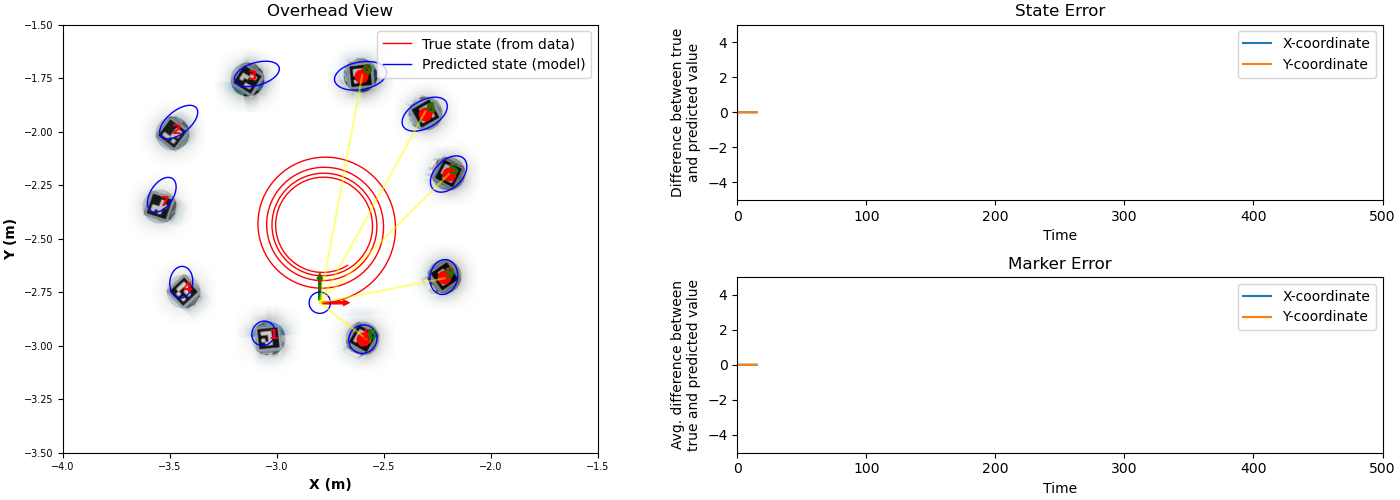

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=299), …

In [12]:
prediction_state, prediction_markers = run_slam(render=True)